In [ ]:
# Installing needed package (triton)
! pip install diffusers transformers accelerate datasets torch torchvision
! pip install wandb
! wandb login # API KEY LOGIN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 124.1 MB/s eta 0:00:00


In [12]:
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import os
import wandb

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [3]:
# Measure data-loading time

start = time.time()
for batch in dataloader:
    x, y = batch
    x = x.to('cuda', non_blocking=True)  # non_blocking works with pin_memory
    y = y.to('cuda', non_blocking=True)
end = time.time()
print(end-start)

11.100947141647339


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Optimized DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,           # Adjust based on your CPU cores
    pin_memory=True,         # Speeds up transfer to GPU
    prefetch_factor=2,       # Number of batches per worker to prefetch
    persistent_workers=True  # Keeps workers alive between epochs
)
device = 'cuda'

In [8]:
start = time.time()
for batch in dataloader:
    x, y = batch
    x = x.to(device, non_blocking=True)  # non_blocking works with pin_memory
    y = y.to(device, non_blocking=True)
end = time.time()
print(end-start)


4.393977403640747


In [9]:
model = UNet2DModel(
    sample_size=32,          
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128),  # Lightweight
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D")
).to("cuda")

In [10]:
scheduler = DDPMScheduler(num_train_timesteps=1000)

In [17]:
wandb.init(
    project="DDPM_Project",          
    name="exp_baseline",             
    config={
        "epochs": 1,
        "lr": 1e-4,
        "batch_size": dataloader.batch_size,
        "scheduler": scheduler.config,
        "model": str(model.__class__.__name__),
    }
)

In [18]:
optimizer = torch.optim.AdamW(model.parameters(), lr=wandb.config.lr)
epochs = wandb.config.epochs
device = "cuda"

# Test with different batch

total_start_time = time.time()
torch.cuda.reset_peak_memory_stats()

for epoch in range(epochs):
    pbar = tqdm(dataloader)
    for step, (x, _) in enumerate(pbar):
        x = x.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (x.shape[0],), device=device).long()

        noisy_x = scheduler.add_noise(x, noise, timesteps)
        noise_pred = model(noisy_x, timesteps).sample

        loss = F.mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

        # Log to W&B
        wandb.log({
            "loss": loss.item(),
            "epoch": epoch + 1,
            "step": step + epoch * len(dataloader),
        })

# Finish W&B run
wandb.finish()

total_end_time = time.time()
print(f"Total Training Time: {total_end_time - total_start_time:.2f}s")
print(f"Peak GPU Memory Usage: {torch.cuda.max_memory_allocated() / (1024 * 1024):.2f} MB")

Epoch 1 | Loss: 0.0426: 100%|██████████| 782/782 [01:57<00:00,  6.67it/s]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▇▃▃█▂▄▆▃▇█▅▅▄▄▄▃▄▄▅▃▄▄▄▅▄▅▄▅▅▅▄▂▁▂▃▂▃▃▃▄
step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch,1
loss,0.0426
step,781


✅ Total Training Time: 118.03s
🔍 Peak GPU Memory Usage: 1478.28 MB


In [22]:
wandb.init(
    project="DDPM_Project",          
    name="exp_MP",             
    config={
        "epochs": 1,
        "lr": 1e-4,
        "batch_size": dataloader.batch_size,
        "scheduler": scheduler.config,
        "model": str(model.__class__.__name__),
    }
)

In [23]:
# Training with Mixed Precision + Gradient Checkpointing #

from torch.cuda.amp import autocast, GradScaler
import time

optimizer = torch.optim.AdamW(model.parameters(), lr=wandb.config.lr)
scaler = GradScaler()  # For scaling gradients in mixed precision
epochs = wandb.config.epochs
device = "cuda"

model.to(device)
model.enable_gradient_checkpointing() # To do gradient checkpointing
model.train()

total_start_time = time.time()
torch.cuda.reset_peak_memory_stats()

for epoch in range(epochs):
    pbar = tqdm(dataloader)
    for step, (x, _) in enumerate(pbar):
        x = x.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (x.shape[0],), device=device).long()

        noisy_x = scheduler.add_noise(x, noise, timesteps)

        optimizer.zero_grad()

        # Mixed precision context
        with autocast():
            noise_pred = model(noisy_x, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)

        # Backprop with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

        # Log to W&B
        wandb.log({
            "loss": loss.item(),
            "epoch": epoch + 1,
            "step": step + epoch * len(dataloader),
        })


# Finish W&B run
wandb.finish()

total_end_time = time.time()
print(f"Total Training Time: {total_end_time - total_start_time:.2f}s")
print(f"Peak GPU Memory Usage: {torch.cuda.max_memory_allocated() / (1024 * 1024):.2f} MB")


/var/tmp/ipykernel_1195988/3998953457.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For scaling gradients in mixed precision
  0%|          | 0/782 [00:00<?, ?it/s]/var/tmp/ipykernel_1195988/3998953457.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 | Loss: 0.0294: 100%|██████████| 782/782 [01:48<00:00,  7.19it/s]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▄▃▄▆▃▄▃▅▁▃▂▄▃▂▃▂▂█▄▃▄▃▅▂▁▂▂▆▁▄▅▂▂▅▃▃▂▁▂▆
step,▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
epoch,1
loss,0.02944
step,781


Total Training Time: 109.42s
Peak GPU Memory Usage: 526.36 MB


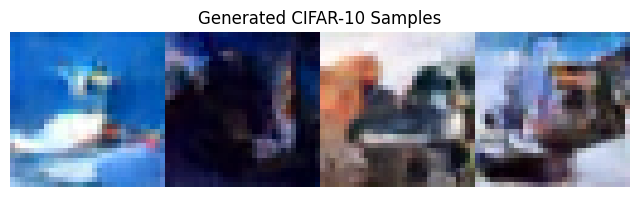

In [24]:
@torch.no_grad()
def sample(model, scheduler, num_images=4):
    model.eval()
    images = torch.randn((num_images, 3, 32, 32)).to(device)
    scheduler.set_timesteps(1000)

    for t in scheduler.timesteps:
        noise_pred = model(images, t).sample
        images = scheduler.step(noise_pred, t, images).prev_sample
        
    return images

samples = sample(model, scheduler, num_images=4)
samples = (samples.clamp(-1, 1) + 1) / 2  # from [-1, 1] to [0, 1]

grid = torch.cat([img for img in samples.cpu()], dim=2).permute(1, 2, 0)
plt.figure(figsize=(8, 8))
plt.imshow(grid.numpy())
plt.axis("off")
plt.title("Generated CIFAR-10 Samples")
plt.show()

## Method d. Operate in the Latent Space #

In [25]:
model = UNet2DModel(
    sample_size=4,           # Size of latent input -> 4x4x4
    in_channels=4,
    out_channels=4,
    layers_per_block=2,
    block_out_channels=(64, 128, 128),  # Lightweight
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D")
).to("cuda")

In [ ]:
from diffusers.models import AutoencoderKL

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.to(device)
vae.eval()  # Freeze VAE during training

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

epochs = 5
device = "cuda"

# Test with different batch

for epoch in range(epochs):
    pbar = tqdm(dataloader)
    for step, (x, _) in enumerate(pbar):
        x = x.to(device)

        with torch.no_grad():
            latents = vae.encode(x).latent_dist.sample()
            latents = latents * 0.18215  # Scaling factor used in SD

        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (x.shape[0],), device=device).long()
        noisy_latents = scheduler.add_noise(latents, noise, timesteps)

        noise_pred = model(noisy_latents, timesteps).sample

        loss = F.mse_loss(noise_pred, noisy_latents)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

Epoch 1 | Loss: 0.0091: 100%|██████████| 782/782 [01:01<00:00, 12.80it/s]
Epoch 2 | Loss: 0.0055:  37%|███▋      | 289/782 [00:23<00:39, 12.51it/s]

100%|██████████| 50/50 [00:01<00:00, 48.21it/s]


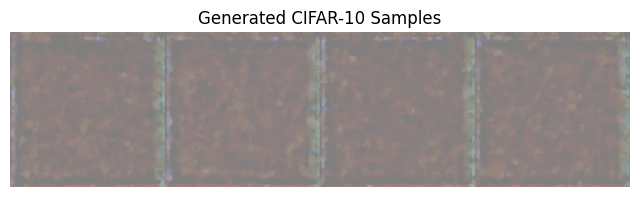

In [39]:
@torch.no_grad()
def sample_latents(model, scheduler, vae, num_images=4, latent_size=(4, 64, 64), num_inference_steps=50):
    model.eval()
    latents = torch.randn((num_images, *latent_size), device=device)
    scheduler.set_timesteps(num_inference_steps, device=device)

    for t in tqdm(scheduler.timesteps):
        noise_pred = model(latents, t).sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode to image
    latents = latents / 0.18215
    images = vae.decode(latents).sample
    images = images.clamp(0, 1).cpu()

    return images


samples = sample_latent(model, scheduler, vae, num_images=4)
samples = (samples.clamp(-1, 1) + 1) / 2  # from [-1, 1] to [0, 1]

grid = torch.cat([img for img in samples.cpu()], dim=2).permute(1, 2, 0)
plt.figure(figsize=(8, 8))
plt.imshow(grid.numpy())
plt.axis("off")
plt.title("Generated CIFAR-10 Samples")
plt.show()

In [35]:
with torch.no_grad():
    x = next(iter(dataloader))[0].to(device)
    latents = vae.encode(x).latent_dist.sample() * 0.18215
    decoded = vae.decode(latents).sample
    decoded = decoded.clamp(0, 1)

# Display or save decoded image
grid = torch.cat([decoded], dim=2).permute(1, 2, 0)
plt.figure(figsize=(8, 8))
plt.imshow(grid.numpy())
plt.axis("off")
plt.title("Generated CIFAR-10 Samples")
plt.show()

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [23]:
samples = sample(model, scheduler, num_images=4)
samples = (samples.clamp(-1, 1) + 1) / 2  # from [-1, 1] to [0, 1]

grid = torch.cat([img for img in samples.cpu()], dim=2).permute(1, 2, 0)
plt.figure(figsize=(8, 8))
plt.imshow(grid.numpy())
plt.axis("off")
plt.title("Generated CIFAR-10 Samples")
plt.show()

RuntimeError: Given groups=1, weight of size [64, 4, 3, 3], expected input[4, 3, 32, 32] to have 4 channels, but got 3 channels instead

In [48]:
from diffusers import UNet2DConditionModel

model = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="unet"
)

In [ ]:
from diffusers.models import AutoencoderKL

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.to(device)
vae.eval()  # Freeze VAE during training

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

epochs = 5
device = "cuda"

# Test with different batch

for epoch in range(epochs):
    pbar = tqdm(dataloader)
    for step, (x, _) in enumerate(pbar):
        x = x.to(device)

        with torch.no_grad():
            latents = vae.encode(x).latent_dist.sample()
            latents = latents * 0.18215  # Scaling factor used in SD

        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (x.shape[0],), device=device).long()
        noisy_latents = scheduler.add_noise(latents, noise, timesteps)

        noise_pred = model(noisy_latents, timesteps).sample

        loss = F.mse_loss(noise_pred, noisy_latents)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")


/var/tmp/ipykernel_612065/44295786.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For scaling gradients in mixed precision
  0%|          | 0/782 [00:00<?, ?it/s]/var/tmp/ipykernel_612065/44295786.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/782 [00:00<?, ?it/s]


TypeError: UNet2DConditionModel.forward() missing 1 required positional argument: 'encoder_hidden_states'

In [46]:
print(torch.cuda.memory_allocated() / 1e6, "MB")

634.765824 MB


In [60]:
from diffusers import UNet2DConditionModel


model = UNet2DModel(
    sample_size=32,           # CIFAR-10 size
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128),  # Lightweight
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D")
).to("cuda")

model.enable_gradient_checkpointing()

In [61]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

epochs = 1
device = "cuda"

# Test with different batch

for epoch in range(epochs):
    pbar = tqdm(dataloader)
    for step, (x, _) in enumerate(pbar):
        x = x.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (x.shape[0],), device=device).long()

        noisy_x = scheduler.add_noise(x, noise, timesteps)
        noise_pred = model(noisy_x, timesteps).sample

        loss = F.mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")
        break

print(torch.cuda.memory_allocated() / 1e6, "MB")

Epoch 1 | Loss: 1.1905:   0%|          | 0/782 [00:00<?, ?it/s]

7785.72032 MB
